# Contents:
* [Context and Data types](#Context-and-Data-types)
* [Context Generation on dummy data](#data-types)
    * [Creating Cotext Object](#con-obj)
* [Causality Discovery](#con-caus)
* [Database Connections](#con-db)
* [Distance Function](#con-dist)
* [Clustering Context](#con-clust)
* [Pipelines](#con-pipe)
* [Simulators](#con-simulator)
    * [Simulator stream](#con-simulator-stream)
    * [Simulator using pandas DataFrame](#con-simulator-df)
* [Limitations](#limitation)

The Documentation can be found [here](/index_old.html)

# Getting Started with Context

In [1]:
from PdmContext.ContextGeneration import ContextGenerator
from PdmContext.utils.structure import Context

/home/agiannoul/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-27 15:25:04,962 - /home/agiannoul/.local/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-02-27 15:25:04,991 - /home/agiannoul/.local/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Context and Data types <a class="anchor" id="Context-and-Data-types"></a>

**Context** is used here to provide a better understanding of the difference cases the data are each time.

In esense Context represent the data (**CD**), existing in a time window, and their relationships (**CR**), where the relationships are extracted using **causal discovery** between the data (the causal discovery method can be user defiend).

**PdmContext.utils.structure.Context** is used to Represent such a context.

## Data Types

### Continiuous (analog, real, Univariate series ...):

To this point **CD** contain data from different sources, and support different sample rates of signals, and event discrete data. The difference in sample rate is handled internally in the context generation process where all the series are maped to a single series sample rate callse **target** series (also reffered to the code and documentation as such): 

1) For series with sample rate higher than that of target, the samples between two timestamps of targets series, are aggregated (mean)
2) For series with lower sample rate, repetition of their values is used.


### Event Data: 

The context suppor also data which are not numeric, but related to some kind of event (events that occur in time). These are oftenly refered as discrete data. To this end the Context support two types of such events:

1) isolated: Event that have instant impact when they occur.
2) configuration: Events that refer to a configuration change that has impact and after its occurance.

The type of events is used to tranform the in to contiuous space and add them to **CD**.

![title](images/CDextraction.png)

### Generating some dummy data to test ContextGeneration <a class="anchor" id="data-types"></a>

In [2]:
import pandas as pd
from random import random

# Create artificially timestamps
start = pd.to_datetime("2023-01-01 00:00:00")
timestamps = [start + pd.Timedelta(minutes=i) for i in range(17)]

# Create a real value time series
data1 = [random() for i in range(17)]

# create a variable of anomaly scores
anomaly1 = [0.2, 0.3, 0.2, 0.1, 0.2, 0.2, 0.1, 0.4, 0.8, 0.7, 0.7, 0.8, 0.7, 0.8, 1, 0.6, 0.7]

# Create a configuration Event series 
# (for example in the below series there was a configuration event in 9th timestamo)
configur = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

# Create isolated Event time series (with occurencies in 1st and 13th timestamps)
spikes = [0 for i in range(len(data1))]
spikes[1] = 1
spikes[13] = 1

## Creating a Context Generation object <a class="anchor" id="con-obj"></a>

Provide the name of the target series, the time window length using the context_horizon parameter, and Causality function to calculate CR (we leave this for later). 

In [3]:
from PdmContext.utils.causal_discovery_functions import calculatewithPc


con_gen = ContextGenerator(target="anomaly1", context_horizon="8 hours", Causalityfunct=calculatewithPc, debug=False)

Iteratevly we pass the data to the Context Generator by calling collec_data() method. Each time we pass a single data sample or event from a single source. This method will return a Context object when we pass data with name of the specified target name

In [4]:
source = "press"
for d1, an1, t1, sp1, con1 in zip(data1, anomaly1, timestamps, spikes, configur):
    con_gen.collect_data(timestamp=t1, source=source, name="data1", value=d1)
    if sp1 == 1:
        con_gen.collect_data(timestamp=t1, source=source, name="spike", type="isolated")
    if con1 == 1:
        con_gen.collect_data(timestamp=t1, source=source, name="config", type="configuration")
    contextTemp = con_gen.collect_data(timestamp=t1, source=source, name="anomaly1", value=an1)

We can plot the last context object which was returned (this object is refered to the last timestamp)
We see in the first plot the CD part of Context and in the second plot the CR (in form of graph).

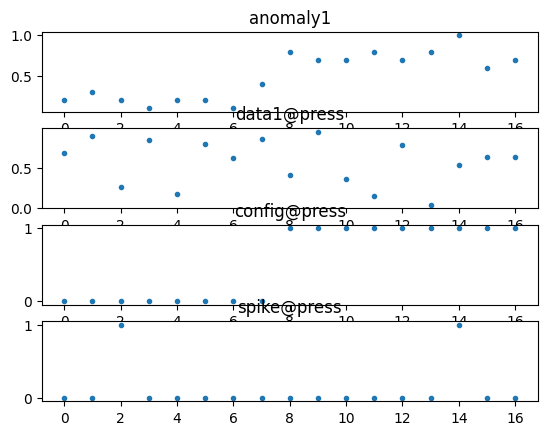

[('anomaly1', 'config@press'), ('config@press', 'anomaly1')]


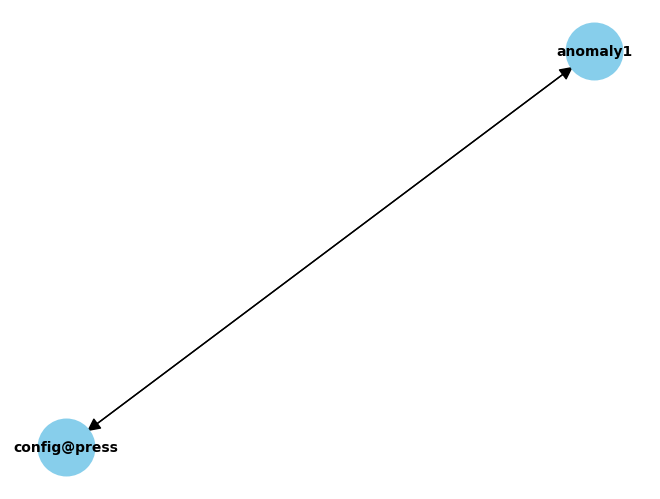

In [5]:
contextTemp.plot()

Moreover we can plot all the context of ContextGeneration (in more abstract level) using plot method.


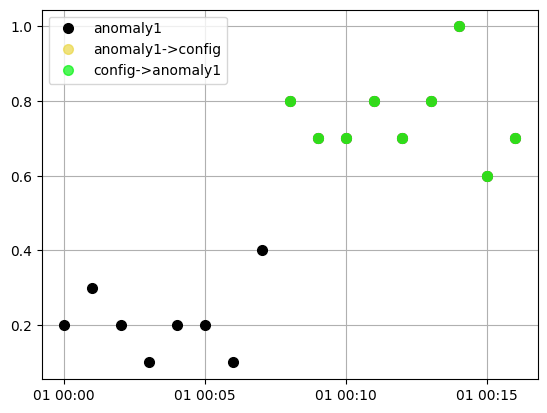

In [6]:
con_gen.plot()

The values on this plot refer to the target value which used to build each context sample, and the colors are refered to the relationshios that exist in the CR of each context object). In that example we can see that the anomaly1 sereis has an increase due to the config event (as seemed from the CR)

## Causality Discovery <a class="anchor" id="con-caus"></a>

The user can implement and provide to the Context Generator its own causality discovery method:

To do this simple needs to implement a python function, that takes as a parameter:

1) A list with names of time series data
2) The time series data in form of 2D array

Example: PdmContext.utils.causal_discovery_functions.calculatewithPc

In [7]:
import networkx as nx
# pip install castle
from castle.algorithms import PC
def calculatewithPc(names, data):
    try:
        pc = PC(variant='parallel')
        pc.learn(data)
    except Exception as e:
        print(e)
        return None

    learned_graph = nx.DiGraph(pc.causal_matrix)
    # Relabel the nodes
    MAPPING = {k: n for k, n in zip(range(len(names)), names)}
    learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)
    edges=learned_graph.edges
    return edges

## Database Connections <a class="anchor" id="con-db"></a>

The current implementation support connection with two databases (SQLlite3 and Influxdb) using the PdmContext.utils.dbconnector.SQLiteHandler, and PdmContext.utils.dbconnector.InfluxDBHandler

Using SQLlite will create a database in the location of the main file. 

Using Influxdb need to start the Influxdb services before start:
(For example in Linux: sudo service influxdb start)


Both databases Connections can be used with implemented pipeline: PdmContext.Pipelines.ContextAndDatabase

Let's generate same example as befor but this time store it to the Database

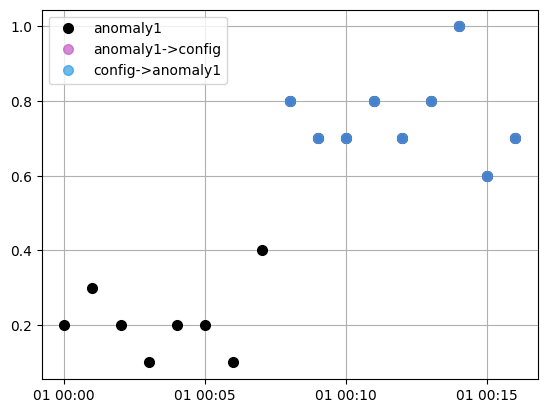

In [8]:
from PdmContext.utils.dbconnector import SQLiteHandler
from PdmContext.Pipelines import ContextAndDatabase


con_gen = ContextGenerator(target="anomaly1", context_horizon="8", Causalityfunct=calculatewithPc, debug=False)
database = SQLiteHandler(db_name="ContextDatabase.db")
contextpipeline = ContextAndDatabase(context_generator_object=con_gen, databaseStore_object=database)

configur = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
data1 = [random() for i in range(len(configur))]
start = pd.to_datetime("2023-01-01 00:00:00")
timestamps = [start + pd.Timedelta(minutes=i) for i in range(len(data1))]
anomaly1 = [0.2, 0.3, 0.2, 0.1, 0.2, 0.2, 0.1, 0.4, 0.8, 0.7, 0.7, 0.8, 0.7, 0.8, 1, 0.6, 0.7]

spikes = [0 for i in range(len(data1))]
spikes[1] = 1
spikes[13] = 1

source = "press"
for d1, an1, t1, sp1, con1 in zip(data1, anomaly1, timestamps, spikes, configur):
    contextpipeline.collect_data(timestamp=t1, source=source, name="data1", value=d1)
    if sp1 == 1:
        contextpipeline.collect_data(timestamp=t1, source=source, name="spike", type="isolated")
    if con1 == 1:
        contextpipeline.collect_data(timestamp=t1, source=source, name="config", type="configuration")
    contextTemp = contextpipeline.collect_data(timestamp=t1, source=source, name="anomaly1", value=an1)
contextpipeline.Contexter.plot()

Now we can acces the Context objexcts stored in the Database:

In [9]:
database = SQLiteHandler(db_name="ContextDatabase.db")
traget_name = "anomaly1"
contextlist = database.get_all_context_by_target(traget_name)
print(len(contextlist))

17


We could also plot the contexts using the helper function from PdmContext.utils.showcontext.show_Context_list


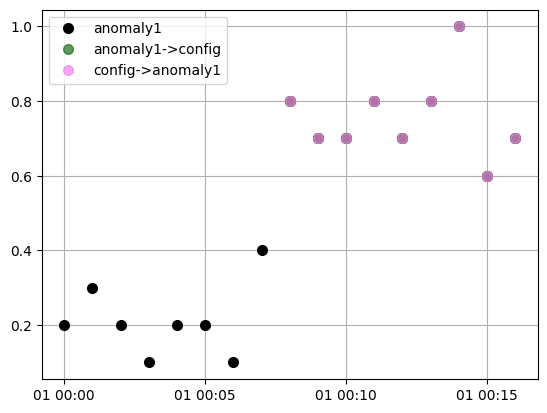

In [10]:
from PdmContext.utils.showcontext import show_Context_list
show_Context_list(contextlist, target_text=traget_name)


We can use filter to exlcude some relationships from the plot (this is quite usefull when many data series are involved)
Althoug there is no practial use in our example, we will now exclude config->anomaly1 relationships and keep only anomaly1->config, which are the same samples (this is done here only for presentation purposes)

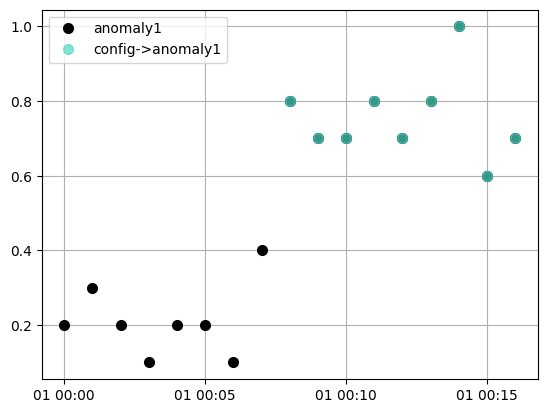

In [11]:
show_Context_list(contextlist, target_text=traget_name, filteredges=[["config", "anomaly1", ""]])


## Distance Function <a class="anchor" id="con-dist"></a>

To compare two Context object we need a similarity (or distacne measure).

The user can implement its own distance function, which accept only two paramters (two Context objects)

Below there is an example which use the distance_cc (which is the SBD distance of between the CD and jaccard similarity between the CR of tte two context weigthed by a factor a and b=1-a)

In this example we builr our own distance function **my_distance(c1: Context,c2 Context)** by using specific a and b

In [12]:
from PdmContext.utils.distances import distance_cc

def my_distance(c1:Context,c2:Context):

    return distance_cc(c1,c2,a=0,b=1)

# JACCARD similarity between the CR components
print(my_distance(contextlist[0],contextlist[-1]))
print(my_distance(contextlist[-2],contextlist[-1]))

0
1.0


## Clustering Context <a class="anchor" id="con-clust"></a>

Using the PdmContext.ContextClustering.DBscanContextStreamClustering we can cluster over Context objects.

Clustering over context object has two main limitations:

1) streaming interface (when we want to cluster the context objects as they arrive from Context Generator
2) appropriate distance measurment

Regarding 1) an example of simplefied DBscan algorithm for streaming data has been developed in PdmContext.ContextClustering.DBscanContextStreamClustering (we can iteratevly feed cluster method using add_sample_to_cluster method)

While for 2) a sample of ditance functions exist in PdmContext.utils.distances, and the user can define its own as shown previously

Creating a PdmContext.ContextClustering.DBscanContextStreamClustering object


[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15, 16]]


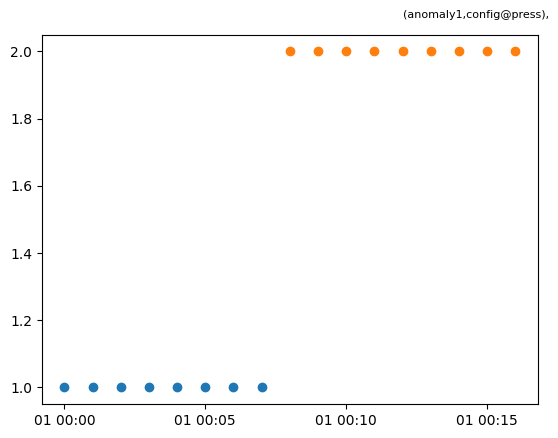

In [13]:
from PdmContext.ContextClustering import DBscanContextStream


# use the distance function from before
clustering=DBscanContextStream(cluster_similarity_limit=0.7,distancefunc=my_distance)

for context_object in contextlist:
    clustering.add_sample_to_cluster(context_object)

print(clustering.clusters_sets)
clustering.plot()

The use of the Cluster and ContextGenerator can be also implemented using the Pipeline ContextAndClustering (PdmContext.Pipelines.ContextAndClustering)

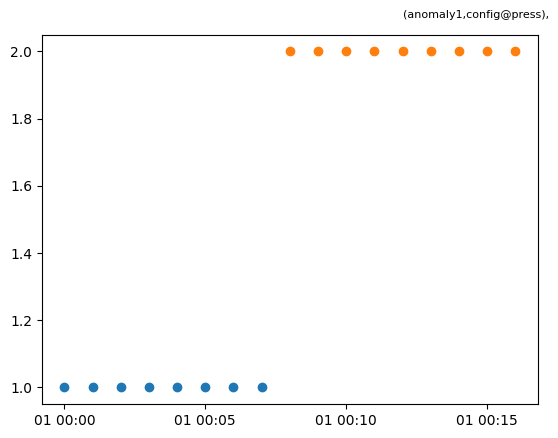

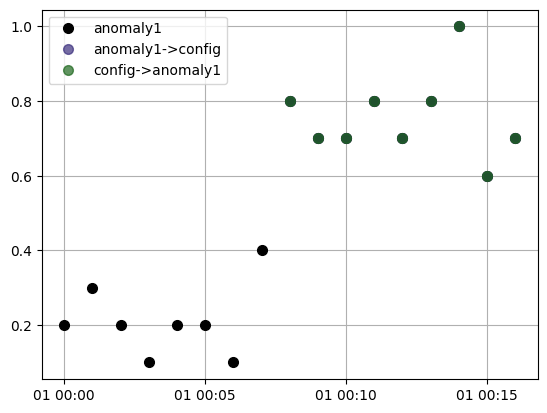

In [14]:
from PdmContext.Pipelines import ContextAndClustering

con_gen_2 = ContextGenerator(target="anomaly1", context_horizon="8 hours", Causalityfunct=calculatewithPc, debug=False)
clustering_2=DBscanContextStream(cluster_similarity_limit=0.7,min_points=2,distancefunc=my_distance)

contextpipeline2 = ContextAndClustering(context_generator_object=con_gen_2,Clustring_object=clustering_2)


source = "press"
for d1, an1, t1, sp1, con1 in zip(data1, anomaly1, timestamps, spikes, configur):
    contextpipeline2.collect_data(timestamp=t1, source=source, name="data1", value=d1)
    if sp1 == 1:
        contextpipeline2.collect_data(timestamp=t1, source=source, name="spike", type="isolated")
    if con1 == 1:
        contextpipeline2.collect_data(timestamp=t1, source=source, name="config", type="configuration")
    contextTemp = contextpipeline2.collect_data(timestamp=t1, source=source, name="anomaly1", value=an1)
contextpipeline2.clustering.plot()
contextpipeline2.Contexter.plot()



## Pipelines <a class="anchor" id="con-pipe"></a>

There are three pipeline which wrap the Database Conenctor, Context Generator and Clustering (all using the same API of collect_data as Context Generator)

1) PdmContext.Pipelines.ContextAndClustering (wrap Context generator and feed its result to clustering)
2) PdmContext.Pipelines import ContextAndDatabase (wrap Context generator and feed its result to database)
3) PdmContext.Pipelines import ContextAndClusteringAndDatabase (wrap Context generator and feed its result to database and clustering)

## Simulators <a class="anchor" id="con-simulator"></a>

Because Context Generator works in streaming fashion there are implemented simulatores that can be used as helpers for the user (PdmContext.utils.simulate_stream)



### Simulator stream <a class="anchor" id="con-simulator-stream"></a>
Example (PdmContext.utils.simulate_stream.simulate_stream): 

This simulator need to pass two list 
1) Time series data : which contain tuples of with shape ( name : str, timestamps :list, values :list )
2) Event series data : which contain tuples of : (name : str, occurencies :list of Dates), type :str)
3) traget name

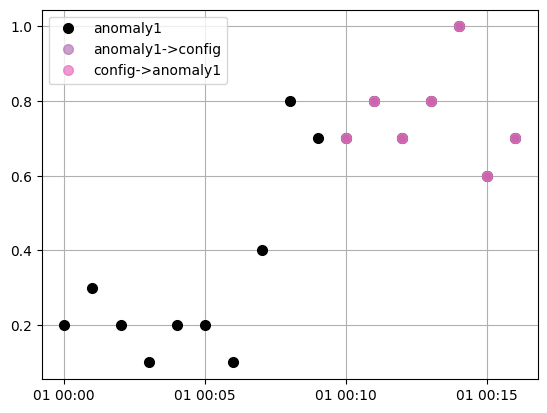

In [21]:
from PdmContext.utils.simulate_stream import simulate_stream


start2 = pd.to_datetime("2023-01-01 00:00:00")
timestamps2 = [start2 + pd.Timedelta(minutes=i) for i in range(17)]

eventconf2=("config",[pd.to_datetime("2023-01-01 00:09:00")],"configuration")
spiketuples2=("spikes",[pd.to_datetime("2023-01-01 00:01:00"),pd.to_datetime("2023-01-01 00:13:00")],"isolated")

data1tuples2=("data1",[random() for i in range(17)],timestamps2)
anomaly1tuples2=("anomaly1", [0.2, 0.3, 0.2, 0.1, 0.2, 0.2, 0.1, 0.4, 0.8, 0.7, 0.7, 0.8, 0.7, 0.8, 1, 0.6, 0.7],timestamps2)

stream=simulate_stream([data1tuples2,anomaly1tuples2],[eventconf2,spiketuples2],"anomaly1")

contextpipeline3 =  ContextGenerator(target="anomaly1", context_horizon="8 hours", Causalityfunct=calculatewithPc)
source="press"


for record in stream:
    #print(record)
    contextpipeline3.collect_data(timestamp=record["timestamp"], source=source, name=record["name"], type=record["type"],value=record["value"]) 
contextpipeline3.plot()

### Simulator using pandas DataFrame <a class="anchor" id="con-simulator-df"></a>

In case of existing dataframe with all data.

Example (PdmContext.utils.simulate_stream.simulate_from_df): 

This simulator need to pass two list 
1) A dataframe
2) Which columns are representing events and of what type example \[("column1","isolated"),("column3","configuration")\]
3) Target name (existing in dataframes column)

                        data1  configur  anomaly1  spikes
2023-01-01 00:00:00  0.263462         0       0.2       0
2023-01-01 00:01:00  0.827615         0       0.3       1
2023-01-01 00:02:00  0.381941         0       0.2       0
2023-01-01 00:03:00  0.327193         0       0.1       0
2023-01-01 00:04:00  0.837698         0       0.2       0


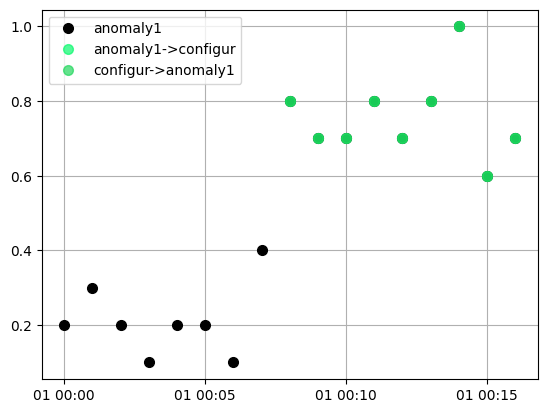

In [17]:
from PdmContext.utils.simulate_stream import simulate_from_df

df = pd.read_csv("dummy_data.csv",index_col=0)
df.index=pd.to_datetime(df.index)
print(df.head())
traget_name="anomaly1"
stream = simulate_from_df(df,[("configur","configuration"),("spikes","isolated")], traget_name)

contextpipeline4 =  ContextGenerator(target="anomaly1", context_horizon="8 hours", Causalityfunct=calculatewithPc)

source = "press"
for record in stream:
    contextpipeline4.collect_data(timestamp=record["timestamp"], source=source, name=record["name"], type=record["type"],value=record["value"]) 
contextpipeline4.plot()

# Limitations <a class="anchor" id="limitation"></a>

1) distances not scalable
2) causality discovery is genreraly slow
3) Context extraction it may be not optimize (for time complexity)